In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, pointbiserialr, spearmanr, f_oneway
from sklearn.metrics import mutual_info_score
from typing import Optional, Union, List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# ==================== PHẦN 1: HÀM VẼ BIỂU ĐỒ ====================

def plot_continuous_histogram(data: pd.Series, bins: int = 30, 
                              title: Optional[str] = None, 
                              figsize: tuple = (10, 6),
                              color: str = 'steelblue',
                              ax: Optional[plt.Axes] = None):
    """
    Vẽ histogram cho biến continuous
    
    Parameters:
    -----------
    data : pd.Series
        Dữ liệu continuous
    bins : int
        Số lượng bins
    title : str
        Tiêu đề biểu đồ
    figsize : tuple
        Kích thước figure (chỉ dùng khi ax=None)
    color : str
        Màu sắc của histogram
    ax : plt.Axes, optional
        Axes để vẽ. Nếu None, tạo figure mới
        
    Returns:
    --------
    plt.Axes
        Axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.hist(data.dropna(), bins=bins, color=color, edgecolor='black', alpha=0.7)
    ax.set_xlabel(data.name if data.name else 'Value')
    ax.set_ylabel('Frequency')
    ax.set_title(title or f'Histogram - {data.name}')
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm thông tin thống kê
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    ax.legend()
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return ax


def plot_discrete_barchart(data: pd.Series, title: Optional[str] = None, 
                           figsize: tuple = (10, 6), 
                           color: str = 'steelblue',
                           ax: Optional[plt.Axes] = None):
    """
    Vẽ bar chart cho biến discrete có ít giá trị (< 10)
    
    Parameters:
    -----------
    data : pd.Series
        Dữ liệu discrete
    title : str
        Tiêu đề biểu đồ
    figsize : tuple
        Kích thước figure (chỉ dùng khi ax=None)
    color : str
        Màu sắc
    ax : plt.Axes, optional
        Axes để vẽ. Nếu None, tạo figure mới
        
    Returns:
    --------
    plt.Axes
        Axes object
    """
    value_counts = data.value_counts().sort_index()
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.bar(range(len(value_counts)), value_counts.values, 
           color=color, edgecolor='black', alpha=0.7)
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Frequency')
    ax.set_xlabel(data.name if data.name else 'Categories')
    ax.set_title(title or f'Value Counts - {data.name}')
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm giá trị lên mỗi cột
    for i, v in enumerate(value_counts.values):
        ax.text(i, v, str(v), ha='center', va='bottom')
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return ax


def plot_nominal_topk_barchart(data: pd.Series, top_k: int = 10, 
                               title: Optional[str] = None, 
                               figsize: tuple = (12, 6),
                               color: str = 'steelblue',
                               others_color: str = 'lightgray',
                               ax: Optional[plt.Axes] = None):
    """
    Vẽ bar chart với Top-K + Others cho biến nominal có nhiều giá trị
    
    Parameters:
    -----------
    data : pd.Series
        Dữ liệu nominal
    top_k : int
        Số lượng top categories
    title : str
        Tiêu đề biểu đồ
    figsize : tuple
        Kích thước figure (chỉ dùng khi ax=None)
    color : str
        Màu sắc cho top categories
    others_color : str
        Màu sắc cho "Others"
    ax : plt.Axes, optional
        Axes để vẽ. Nếu None, tạo figure mới
        
    Returns:
    --------
    plt.Axes
        Axes object
    """
    value_counts = data.value_counts()
    
    if len(value_counts) > top_k:
        top_values = value_counts.head(top_k)
        others_count = value_counts.iloc[top_k:].sum()
        plot_data = pd.concat([top_values, pd.Series({'Others': others_count})])
        colors = [color] * top_k + [others_color]
    else:
        plot_data = value_counts
        colors = [color] * len(plot_data)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.bar(range(len(plot_data)), plot_data.values, color=colors, edgecolor='black', alpha=0.7)
    ax.set_xticks(range(len(plot_data)))
    ax.set_xticklabels(plot_data.index, rotation=45, ha='right')
    ax.set_ylabel('Frequency')
    ax.set_xlabel(data.name if data.name else 'Categories')
    ax.set_title(title or f'Top-{top_k} Categories with Others - {data.name}')
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm phần trăm
    total = plot_data.sum()
    for i, v in enumerate(plot_data.values):
        pct = (v / total) * 100
        ax.text(i, v, f'{v}\n({pct:.1f}%)', ha='center', va='bottom')
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return ax


def plot_grouped_bar_vs_target(data: pd.DataFrame, feature: str, target: str,
                               title: Optional[str] = None, 
                               figsize: tuple = (14, 6),
                               count_color: str = 'steelblue',
                               rate_color: str = 'coral',
                               ax: Optional[plt.Axes] = None):
    """
    Vẽ grouped bar chart: Value counts vs Default rate cho biến discrete < 10 giá trị
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chứa dữ liệu
    feature : str
        Tên cột feature
    target : str
        Tên cột target (0/1)
    title : str
        Tiêu đề biểu đồ
    figsize : tuple
        Kích thước figure (chỉ dùng khi ax=None)
    count_color : str
        Màu cho count bars
    rate_color : str
        Màu cho default rate bars
    ax : plt.Axes, optional
        Axes để vẽ. Nếu None, tạo figure mới
        
    Returns:
    --------
    tuple
        (ax1, ax2) - Hai axes objects
    """
    # Tính default rate và counts
    counts = data[feature].value_counts().sort_index()
    default_rate = data.groupby(feature)[target].mean() * 100
    default_rate = default_rate.reindex(counts.index)
    
    # Vẽ biểu đồ
    if ax is None:
        fig, ax1 = plt.subplots(figsize=figsize)
    else:
        ax1 = ax
    
    x = np.arange(len(counts))
    width = 0.35
    
    # Bar 1: Counts
    ax1.bar(x - width/2, counts.values, width, label='Count', 
            color=count_color, edgecolor='black')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count', color=count_color)
    ax1.tick_params(axis='y', labelcolor=count_color)
    ax1.set_xticks(x)
    ax1.set_xticklabels(counts.index, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar 2: Default rate
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, default_rate.values, width, label='Default Rate (%)', 
            color=rate_color, edgecolor='black')
    ax2.set_ylabel('Default Rate (%)', color=rate_color)
    ax2.tick_params(axis='y', labelcolor=rate_color)
    
    ax1.set_title(title or f'{feature} - Count vs Default Rate')
    
    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return ax1, ax2


def plot_continuous_violin_vs_target(data: pd.DataFrame, feature: str, target: str,
                                    title: Optional[str] = None, 
                                    figsize: tuple = (10, 6),
                                    palette: Union[str, List[str]] = 'Set2',
                                    ax: Optional[plt.Axes] = None):
    """
    Vẽ violin plot: Continuous feature vs TARGET
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chứa dữ liệu
    feature : str
        Tên cột feature (continuous)
    target : str
        Tên cột target
    title : str
        Tiêu đề biểu đồ
    figsize : tuple
        Kích thước figure (chỉ dùng khi ax=None)
    palette : str or list
        Palette màu cho seaborn
    ax : plt.Axes, optional
        Axes để vẽ. Nếu None, tạo figure mới
        
    Returns:
    --------
    plt.Axes
        Axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    plot_data = data[[feature, target]].dropna()
    
    sns.violinplot(data=plot_data, x=target, y=feature, palette=palette, ax=ax)
    ax.set_xlabel(f'{target} (0: Non-Default, 1: Default)')
    ax.set_ylabel(feature)
    ax.set_title(title or f'{feature} Distribution by {target}')
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm thông tin mean
    for i, target_val in enumerate(sorted(plot_data[target].unique())):
        mean_val = plot_data[plot_data[target] == target_val][feature].mean()
        ax.text(i, mean_val, f'Mean: {mean_val:.2f}', 
                ha='center', va='center', fontweight='bold', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return ax


def plot_nominal_amplitude_analysis(data: pd.DataFrame, feature: str, target: str,
                                   top_n: int = 10, title: Optional[str] = None,
                                   figsize: tuple = (14, 8),
                                   non_default_color: str = 'steelblue',
                                   default_color: str = 'coral',
                                   positive_color: str = 'red',
                                   negative_color: str = 'blue'):
    """
    Vẽ histogram/bar chart riêng cho 2 nhóm target với top N categories 
    có biên độ chênh lệch lớn nhất
    
    Biên độ = |tỉ lệ default - tỉ lệ non-default| / trung bình tỉ lệ
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chứa dữ liệu
    feature : str
        Tên cột feature (nominal)
    target : str
        Tên cột target (0/1)
    top_n : int
        Số lượng top categories hiển thị
    title : str
        Tiêu đề biểu đồ
    figsize : tuple
        Kích thước figure
    non_default_color : str
        Màu cho non-default
    default_color : str
        Màu cho default
    positive_color : str
        Màu cho amplitude dương (higher in default)
    negative_color : str
        Màu cho amplitude âm (higher in non-default)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa thông tin biên độ của các categories
    """
    # Tính tỉ lệ cho mỗi category trong từng nhóm target
    total_default = data[data[target] == 1].shape[0]
    total_non_default = data[data[target] == 0].shape[0]
    
    # Tính phân phối phần trăm
    default_dist = data[data[target] == 1][feature].value_counts() / total_default * 100
    non_default_dist = data[data[target] == 0][feature].value_counts() / total_non_default * 100
    
    # Tạo DataFrame kết hợp
    amplitude_df = pd.DataFrame({
        'default_pct': default_dist,
        'non_default_pct': non_default_dist
    }).fillna(0)
    
    # Tính biên độ
    amplitude_df['diff'] = amplitude_df['default_pct'] - amplitude_df['non_default_pct']
    amplitude_df['avg'] = (amplitude_df['default_pct'] + amplitude_df['non_default_pct']) / 2
    amplitude_df['amplitude'] = np.abs(amplitude_df['diff']) / (amplitude_df['avg'] + 1e-10)
    
    # Sắp xếp theo biên độ và lấy top N
    amplitude_df = amplitude_df.sort_values('amplitude', ascending=False).head(top_n)
    
    # Vẽ biểu đồ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    categories = amplitude_df.index
    x = np.arange(len(categories))
    width = 0.35
    
    # Biểu đồ 1: So sánh tỉ lệ phần trăm
    ax1.bar(x - width/2, amplitude_df['non_default_pct'], width, 
            label='Non-Default (0)', color=non_default_color, edgecolor='black')
    ax1.bar(x + width/2, amplitude_df['default_pct'], width, 
            label='Default (1)', color=default_color, edgecolor='black')
    ax1.set_xlabel('Categories')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title(f'Distribution Comparison (Top {top_n})')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Biểu đồ 2: Biên độ
    colors = [positive_color if d > 0 else negative_color for d in amplitude_df['diff']]
    ax2.barh(range(len(categories)), amplitude_df['amplitude'], color=colors, 
             edgecolor='black', alpha=0.7)
    ax2.set_yticks(range(len(categories)))
    ax2.set_yticklabels(categories)
    ax2.set_xlabel('Amplitude Score')
    ax2.set_title(f'Amplitude (Top {top_n})')
    ax2.grid(axis='x', alpha=0.3)
    
    # Thêm chú thích màu
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=positive_color, label='Higher in Default'),
                      Patch(facecolor=negative_color, label='Higher in Non-Default')]
    ax2.legend(handles=legend_elements, loc='lower right')
    
    plt.suptitle(title or f'{feature} - Amplitude Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return amplitude_df[['default_pct', 'non_default_pct', 'diff', 'amplitude']].round(3)


def plot_ordinal_ordered_bar_vs_target(data: pd.DataFrame, feature: str, target: str,
                                      n_bins: int = 10, title: Optional[str] = None,
                                      figsize: tuple = (14, 6),
                                      count_color: str = 'steelblue',
                                      rate_color: str = 'coral',
                                      ax: Optional[plt.Axes] = None):
    """
    Vẽ ordered bar chart cho biến ordinal/continuous vs TARGET
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chứa dữ liệu
    feature : str
        Tên cột feature (ordinal/continuous)
    target : str
        Tên cột target (0/1)
    n_bins : int
        Số lượng bins (nếu là continuous)
    title : str
        Tiêu đề biểu đồ
    figsize : tuple
        Kích thước figure (chỉ dùng khi ax=None)
    count_color : str
        Màu cho count bars
    rate_color : str
        Màu cho default rate bars
    ax : plt.Axes, optional
        Axes để vẽ. Nếu None, tạo figure mới
        
    Returns:
    --------
    tuple
        (ax1, ax2) - Hai axes objects
    """
    plot_data = data[[feature, target]].dropna()
    
    # Kiểm tra xem có phải continuous không
    if plot_data[feature].dtype in ['float64', 'float32'] or plot_data[feature].nunique() > 20:
        # Chia thành bins
        plot_data['bin'] = pd.qcut(plot_data[feature], q=n_bins, duplicates='drop')
        group_col = 'bin'
    else:
        # Giữ nguyên nếu là ordinal
        group_col = feature
    
    # Tính default rate và count
    bin_stats = plot_data.groupby(group_col).agg({
        target: ['mean', 'count']
    })
    bin_stats.columns = ['default_rate', 'count']
    bin_stats['default_rate'] *= 100
    
    # Vẽ biểu đồ
    if ax is None:
        fig, ax1 = plt.subplots(figsize=figsize)
    else:
        ax1 = ax
    
    x = np.arange(len(bin_stats))
    width = 0.35
    
    # Bar 1: Counts
    ax1.bar(x - width/2, bin_stats['count'], width, label='Count',
            color=count_color, edgecolor='black')
    ax1.set_xlabel(f'{feature} (Ordered)')
    ax1.set_ylabel('Count', color=count_color)
    ax1.tick_params(axis='y', labelcolor=count_color)
    ax1.set_xticks(x)
    
    # Format labels
    if group_col == 'bin':
        labels = [f'{interval.left:.2f}-{interval.right:.2f}' for interval in bin_stats.index]
    else:
        labels = bin_stats.index
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar 2: Default rate
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, bin_stats['default_rate'], width, label='Default Rate (%)',
            color=rate_color, edgecolor='black')
    ax2.set_ylabel('Default Rate (%)', color=rate_color)
    ax2.tick_params(axis='y', labelcolor=rate_color)
    
    # Thêm trend line cho default rate
    ax2.plot(x, bin_stats['default_rate'], 'ro-', linewidth=2, markersize=8, 
             label='Trend', alpha=0.6)
    
    ax1.set_title(title or f'{feature} - Ordered Analysis vs {target}')
    
    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return ax1, ax2
# ==================== PHẦN 2: HÀM TÍNH METRICS ====================

def calculate_continuous_metrics(data: pd.Series, target: Optional[pd.Series] = None) -> pd.DataFrame:
    """
    Tính metrics cho biến continuous
    
    Parameters:
    -----------
    data : pd.Series
        Dữ liệu continuous
    target : pd.Series, optional
        Cột target (0/1) để tính ANOVA F-test
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa các metrics
    """
    clean_data = data.dropna()
    
    metrics = {
        'Feature': [data.name or 'Unknown'],
        'Count': [len(clean_data)],
        'Missing': [len(data) - len(clean_data)],
        'Mean': [clean_data.mean()],
        'Median': [clean_data.median()],
        'Std': [clean_data.std()],
        'Min': [clean_data.min()],
        'Max': [clean_data.max()],
        'Skewness': [stats.skew(clean_data)],
        'Kurtosis': [stats.kurtosis(clean_data)]
    }
    
    # Tính ANOVA F-test nếu có target
    if target is not None:
        aligned_data = pd.DataFrame({'feature': data, 'target': target}).dropna()
        groups = [aligned_data[aligned_data['target'] == val]['feature'].values 
                 for val in aligned_data['target'].unique()]
        f_stat, p_value = f_oneway(*groups)
        metrics['ANOVA_F_Statistic'] = [f_stat]
        metrics['ANOVA_P_Value'] = [p_value]
    
    return pd.DataFrame(metrics)


def calculate_nominal_metrics(data: pd.Series) -> pd.DataFrame:
    """
    Tính metrics cho biến nominal
    
    Parameters:
    -----------
    data : pd.Series
        Dữ liệu nominal
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa các metrics
    """
    value_counts = data.value_counts()
    
    metrics = {
        'Feature': [data.name or 'Unknown'],
        'Count': [len(data.dropna())],
        'Missing': [data.isna().sum()],
        'Unique_Values': [data.nunique()],
        'Mode': [data.mode()[0] if len(data.mode()) > 0 else None],
        'Mode_Frequency': [value_counts.iloc[0] if len(value_counts) > 0 else 0],
        'Mode_Percentage': [value_counts.iloc[0] / len(data.dropna()) * 100 if len(value_counts) > 0 else 0]
    }
    
    return pd.DataFrame(metrics)


def calculate_ordinal_metrics(data: pd.Series, order_mapping: Optional[Dict] = None) -> pd.DataFrame:
    """
    Tính metrics cho biến ordinal
    
    Parameters:
    -----------
    data : pd.Series
        Dữ liệu ordinal
    order_mapping : dict, optional
        Mapping từ categories sang numeric values
        Ví dụ: {'Low': 1, 'Medium': 2, 'High': 3}
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa distribution by order
    """
    value_counts = data.value_counts()
    
    if order_mapping:
        # Sắp xếp theo order
        ordered_values = sorted(value_counts.index, key=lambda x: order_mapping.get(x, 0))
        value_counts = value_counts.reindex(ordered_values)
    else:
        value_counts = value_counts.sort_index()
    
    metrics_df = pd.DataFrame({
        'Order': range(1, len(value_counts) + 1),
        'Category': value_counts.index,
        'Frequency': value_counts.values,
        'Percentage': (value_counts.values / value_counts.sum() * 100).round(2),
        'Cumulative_Percentage': (value_counts.values / value_counts.sum() * 100).cumsum().round(2)
    })
    
    metrics_df.attrs['feature_name'] = data.name or 'Unknown'
    
    return metrics_df

def calculate_target_relationship_discrete_few_nunique(data: pd.DataFrame, feature: str, 
                                          target: str) -> pd.DataFrame:
    """
    TÃ­nh metrics quan há»‡ vá»›i TARGET cho biáº¿n discrete
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chá»©a dá»¯ liá»‡u
    feature : str
        TÃªn cá»™t feature
    target : str
        TÃªn cá»™t target (0/1)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chá»©a cÃ¡c metrics
    """
    clean_data = data[[feature, target]].dropna()
    n_unique = clean_data[feature].nunique()
    
    metrics = {
        'Feature': [feature],
        'Unique_Values': [n_unique]
    }
    
    # Chi-Squared Test vÃ  CramÃ©r's V 
    contingency_table = pd.crosstab(clean_data[feature], clean_data[target])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    metrics['Chi2_Statistic'] = [chi2]
    metrics['Chi2_P_Value'] = [p_value]
    metrics['Cramers_V'] = [cramers_v]

    
    
    return pd.DataFrame(metrics)
def calculate_target_relationship_discrete_many_nunique(data: pd.DataFrame, feature: str, 
                                          target: str) -> pd.DataFrame:
    """
    TÃ­nh metrics quan há»‡ vá»›i TARGET cho biáº¿n discrete
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chá»©a dá»¯ liá»‡u
    feature : str
        TÃªn cá»™t feature
    target : str
        TÃªn cá»™t target (0/1)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chá»©a cÃ¡c metrics
    """
    clean_data = data[[feature, target]].dropna()
    n_unique = clean_data[feature].nunique()
    
    metrics = {
        'Feature': [feature],
        'Unique_Values': [n_unique]
    }
    # Point Biserial Correlation
    # Encode feature as numeric (label encoding)
    feature_encoded = clean_data[feature].astype('category').cat.codes
    corr, p_val = pointbiserialr(clean_data[target], feature_encoded)
    metrics['Point_Biserial_Correlation'] = [corr]
    metrics['Point_Biserial_P_Value'] = [p_val]
        
    # Information Value (IV)
    iv = calculate_iv(clean_data, feature, target)
    metrics['Information_Value'] = [iv]
    return pd.DataFrame(metrics)



def calculate_target_relationship_continuous(data: pd.DataFrame, feature: str,
                                            target: str) -> pd.DataFrame:
    """
    Tính metrics quan hệ với TARGET cho biến continuous
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chứa dữ liệu
    feature : str
        Tên cột feature
    target : str
        Tên cột target (0/1)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa các metrics
    """
    clean_data = data[[feature, target]].dropna()
    
    metrics = {
        'Feature': [feature]
    }
    
    # Point Biserial Correlation
    corr, p_val = pointbiserialr(clean_data[target], clean_data[feature])
    metrics['Point_Biserial_Correlation'] = [corr]
    metrics['Point_Biserial_P_Value'] = [p_val]
    
    # ANOVA F-test
    groups = [clean_data[clean_data[target] == val][feature].values
             for val in clean_data[target].unique()]
    f_stat, p_value = f_oneway(*groups)
    metrics['ANOVA_F_Statistic'] = [f_stat]
    metrics['ANOVA_P_Value'] = [p_value]
    
    return pd.DataFrame(metrics)


def calculate_target_relationship_nominal(data: pd.DataFrame, feature: str,
                                         target: str) -> pd.DataFrame:
    """
    Tính metrics quan hệ với TARGET cho biến nominal
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chứa dữ liệu
    feature : str
        Tên cột feature
    target : str
        Tên cột target (0/1)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa các metrics
    """
    clean_data = data[[feature, target]].dropna()
    
    metrics = {
        'Feature': [feature],
        'Unique_Values': [clean_data[feature].nunique()]
    }
    
    # Chi-Squared Test và Cramér's V
    contingency_table = pd.crosstab(clean_data[feature], clean_data[target])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    metrics['Chi2_Statistic'] = [chi2]
    metrics['Chi2_P_Value'] = [p_value]
    metrics['Cramers_V'] = [cramers_v]
    
    # Information Value
    iv = calculate_iv(clean_data, feature, target)
    metrics['Information_Value'] = [iv]
    
    # Mutual Information
    mi = mutual_info_score(clean_data[feature].astype(str), clean_data[target])
    metrics['Mutual_Information'] = [mi]
    
    return pd.DataFrame(metrics)


def calculate_target_relationship_ordinal(data: pd.DataFrame, feature: str,
                                         target: str, 
                                         order_mapping: Optional[Dict] = None) -> pd.DataFrame:
    """
    Tính metrics quan hệ với TARGET cho biến ordinal
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chứa dữ liệu
    feature : str
        Tên cột feature
    target : str
        Tên cột target (0/1)
    order_mapping : dict, optional
        Mapping từ categories sang numeric values
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa các metrics
    """
    clean_data = data[[feature, target]].dropna()
    
    metrics = {
        'Feature': [feature]
    }
    
    # Map ordinal to numeric nếu có mapping
    if order_mapping:
        feature_numeric = clean_data[feature].map(order_mapping)
    else:
        # Tự động encode
        feature_numeric = clean_data[feature].astype('category').cat.codes
    
    # Spearman Correlation
    spearman_corr, spearman_p = spearmanr(feature_numeric, clean_data[target])
    metrics['Spearman_Correlation'] = [spearman_corr]
    metrics['Spearman_P_Value'] = [spearman_p]
    
    # Point Biserial Correlation (sau khi map sang numeric)
    pb_corr, pb_p = pointbiserialr(clean_data[target], feature_numeric)
    metrics['Point_Biserial_Correlation'] = [pb_corr]
    metrics['Point_Biserial_P_Value'] = [pb_p]
    
    return pd.DataFrame(metrics)


def calculate_iv(data: pd.DataFrame, feature: str, target: str) -> float:
    """
    Tính Information Value (IV)
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame chứa dữ liệu
    feature : str
        Tên cột feature
    target : str
        Tên cột target (0/1)
        
    Returns:
    --------
    float
        Information Value
    """
    # Tạo crosstab
    ct = pd.crosstab(data[feature], data[target], normalize='columns')
    
    if ct.shape[1] < 2:
        return 0.0
    
    # Tính WoE và IV
    good_pct = ct[0] + 0.0001  # Tránh log(0)
    bad_pct = ct[1] + 0.0001
    woe = np.log(bad_pct / good_pct)
    iv = ((bad_pct - good_pct) * woe).sum()
    
    return iv


In [3]:
df = pd.read_csv('../raw_data/train.csv')

<Axes: title={'center': 'Histogram - AMT_ANNUITY'}, xlabel='AMT_ANNUITY', ylabel='Frequency'>

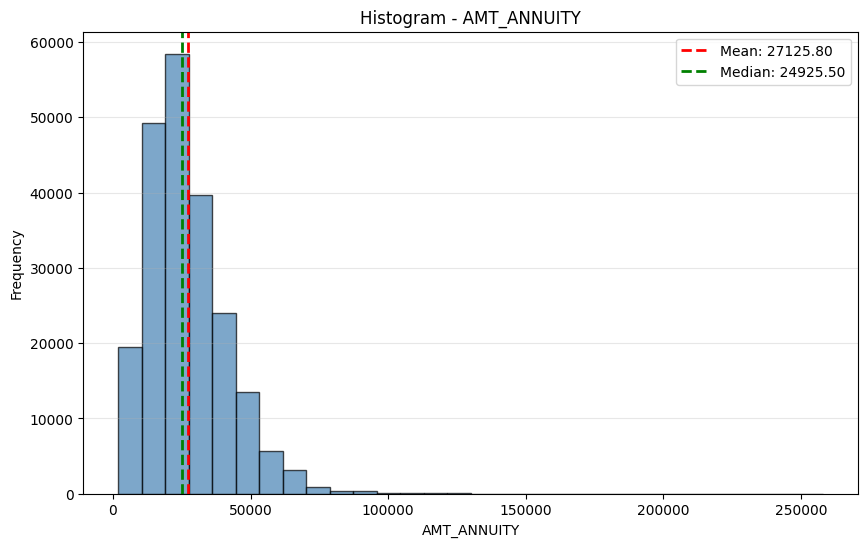

In [4]:
plot_continuous_histogram(df['AMT_ANNUITY'])

<Axes: title={'center': 'Histogram - AMT_ANNUITY'}, xlabel='AMT_ANNUITY', ylabel='Frequency'>

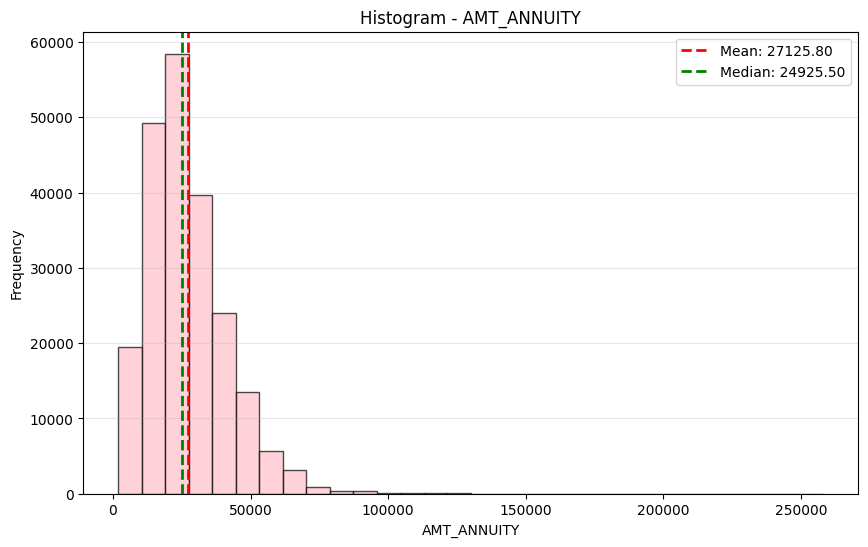

In [5]:
# Cách 1: Vẽ riêng lẻ
plot_continuous_histogram(df['AMT_ANNUITY'], color = 'pink')

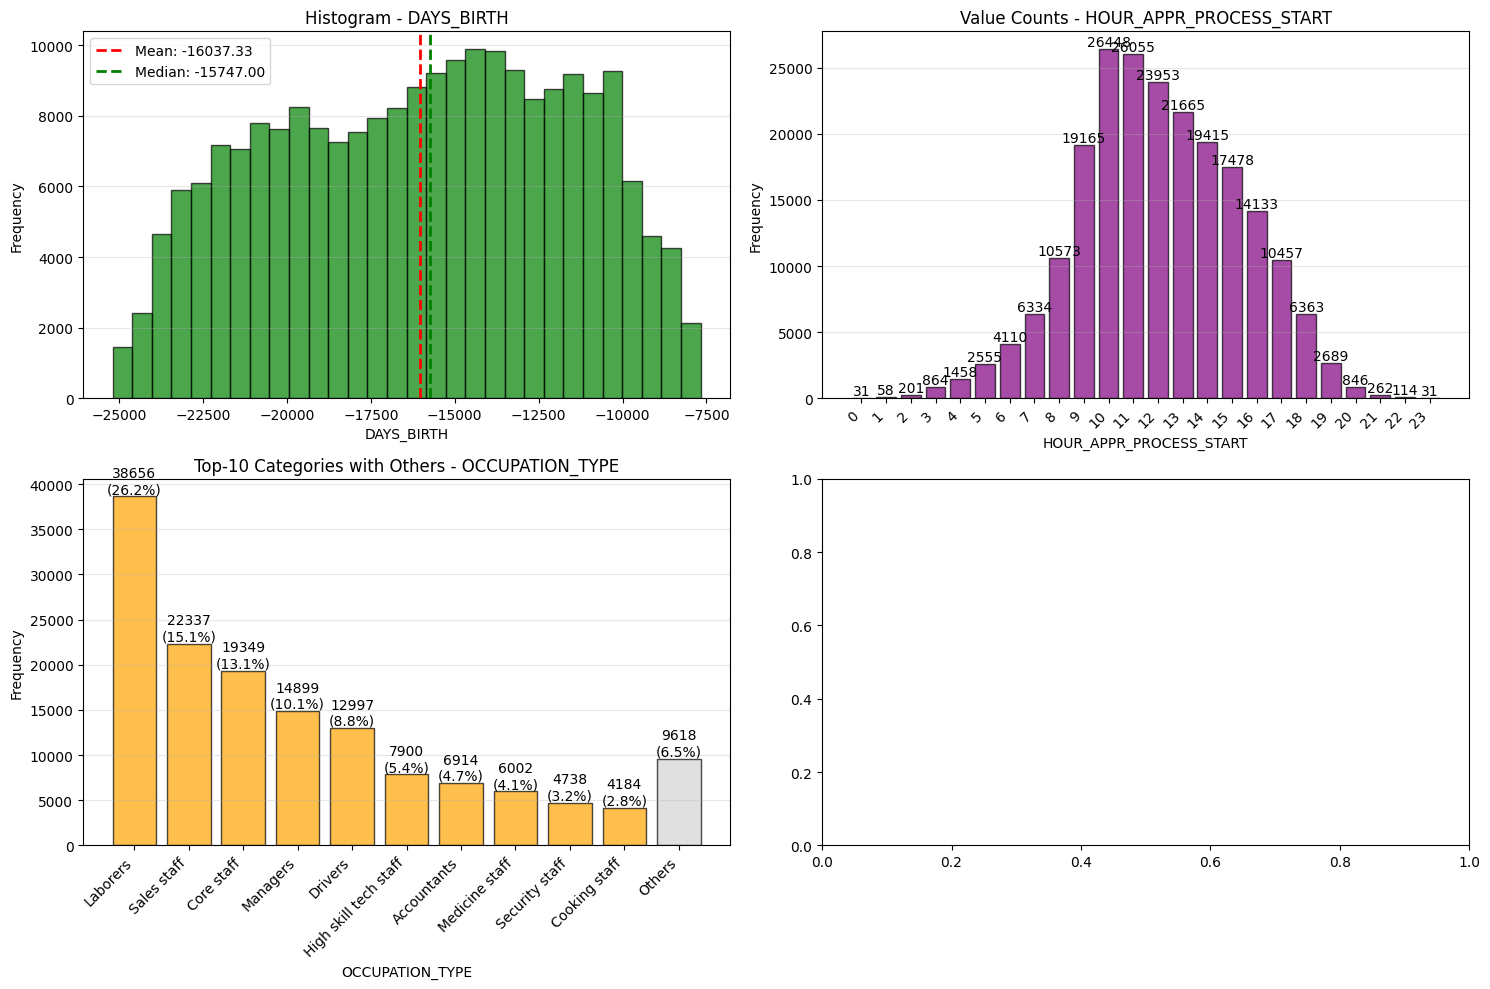

In [6]:
# Cách 2: Vẽ vào subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plot_continuous_histogram(df['DAYS_BIRTH'], color='green', ax=axes[0, 0])
plot_discrete_barchart(df['HOUR_APPR_PROCESS_START'], color='purple', ax=axes[0, 1])
plot_nominal_topk_barchart(df['OCCUPATION_TYPE'], color='orange', ax=axes[1, 0])
plt.tight_layout()
plt.show()

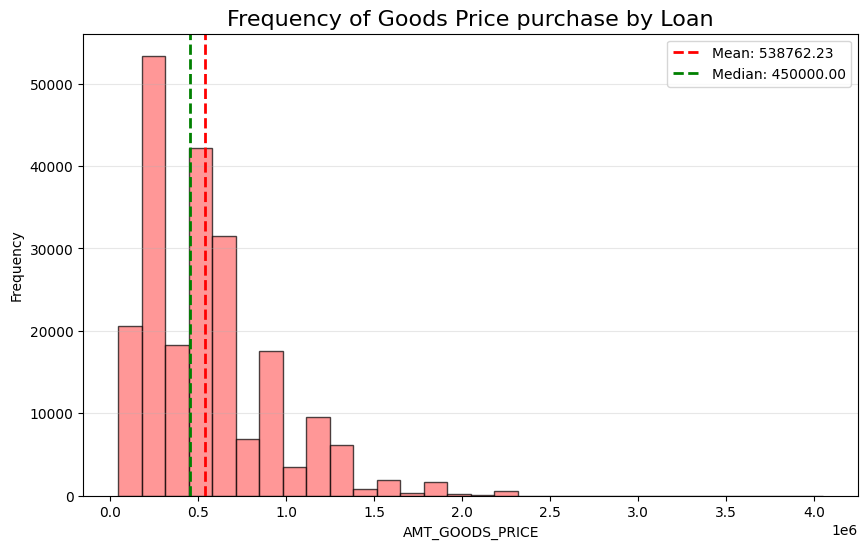

In [12]:
# Cách 3: Customize thêm sau khi vẽ
ax = plot_continuous_histogram(df['AMT_GOODS_PRICE'], color='#FF6B6B')
ax.set_title('Frequency of Goods Price purchase by Loan', fontsize=16)
plt.show()

In [14]:
# Xác định các loại biến (dùng để đối chiếu):
def classify_variables(df):
    discrete_vars = []
    continuous_vars = []
    ordinal_vars = ['NAME_EDUCATION_TYPE']
    nominal_vars = []

    # Loop through all columns
    for col in df.columns:
        
        # Skip ordinal variable from nominal scanning
        if col == 'NAME_EDUCATION_TYPE':
            continue
        
        # Identify numeric variables
        if pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() <= 20:
                discrete_vars.append(col)
            else:
                continuous_vars.append(col)
        
        # Identify categorical variables → nominal
        elif df[col].dtype == 'object':
            nominal_vars.append(col)

    # Output result as dictionary
    return {
        "discrete_variables": discrete_vars,
        "continuous_variables": continuous_vars,
        "ordinal_variables": ordinal_vars,
        "nominal_variables": nominal_vars
    }
variable_types = classify_variables(df)
print(variable_types)

{'discrete_variables': ['TARGET', 'CNT_CHILDREN', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT'], 'continuous_variables': ['ID', 'AMT_INCO